In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import Sampler

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy import stats
import itertools

/Users/kx/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import random
random.seed(42)

import torch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [3]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

## Define Dataset

In [4]:
# Function to assign source names to the dataset equally
def assign_sources_equally(dataset, sources=('A', 'B', 'C', 'D', 'E', 'F')):
    num_sources = len(sources)
    num_data = len(dataset)
    num_each = num_data // num_sources
    
    # Convert sources to a list if it's a tuple
    sources_list = list(sources)
    
    # Create a list of source labels, each repeated equally
    source_labels = sources_list * num_each + [sources_list[i] for i in range(num_data % num_sources)]
    
    # Shuffle the labels to randomize their order
    np.random.shuffle(source_labels)
    
    return source_labels

# Assign sources to training and test data
training_sources = assign_sources_equally(training_data)
test_sources = assign_sources_equally(test_data)

# Example of how you can use the assigned sources
print("First 10 source labels for training data:", training_sources[:10])

First 10 source labels for training data: ['E', 'A', 'D', 'A', 'D', 'F', 'A', 'A', 'D', 'B']


In [5]:
# Function to assign participants to train and test datasets
def assign_participants_to_train_and_test(train_labels, test_labels, num_train_participants_per_source, train_images_per_participant, num_test_participants_per_source):
    train_participants = {source: [] for source in set(train_labels)}
    test_participants = {source: [] for source in set(test_labels)}
    
    # Calculate number of test images for participants
    num_test_participants_total = num_test_participants_per_source * len(test_participants)
    test_images_per_participant = 10000 // num_test_participants_total
    extra_test_images = 10000 % num_test_participants_total

    # Assign participants for training
    global_participant_id = 0
    for source in train_participants:
        train_indices = [i for i, s in enumerate(train_labels) if s == source]
        np.random.shuffle(train_indices)
        
        for i in range(num_train_participants_per_source):
            train_participant_indices = train_indices[i * train_images_per_participant: (i + 1) * train_images_per_participant]
            train_participants[source].append((global_participant_id, train_participant_indices))
            global_participant_id += 1

    # Assign participants for testing
    for source in test_participants:
        test_indices = [i for i, s in enumerate(test_labels) if s == source]
        np.random.shuffle(test_indices)
        
        for i in range(num_test_participants_per_source):
            if i < extra_test_images:
                test_participant_indices = test_indices[i * (test_images_per_participant + 1): (i + 1) * (test_images_per_participant + 1)]
            else:
                test_participant_indices = test_indices[i * test_images_per_participant: (i + 1) * test_images_per_participant]
            test_participants[source].append((global_participant_id, test_participant_indices))
            global_participant_id += 1

    return train_participants, test_participants

def count_unique_participants(participants):
    unique_participants = set()
    for source, participant_info in participants.items():
        for participant_id, _ in participant_info:
            unique_participants.add(participant_id)
    return len(unique_participants)

# Example data
training_data_indices = np.arange(60000)
test_data_indices = np.arange(10000)

# Assign sources to training and test data
training_sources = assign_sources_equally(training_data_indices)
test_sources = assign_sources_equally(test_data_indices)

# Parameters
num_train_participants_per_source = 10
num_test_participants_per_source = 2
train_images_per_participant = 1000

# Assign participant IDs to both training and test data
train_participants, test_participants = assign_participants_to_train_and_test(
    training_sources, test_sources, num_train_participants_per_source, train_images_per_participant, num_test_participants_per_source)

# Count unique participants in training and test datasets separately
num_unique_train_participants = count_unique_participants(train_participants)
num_unique_test_participants = count_unique_participants(test_participants)

print(f"Number of unique participants in training data: {num_unique_train_participants}")
print(f"Number of unique participants in test data: {num_unique_test_participants}")

# Example of how you can use the assigned participants
for source, participant_info in train_participants.items():
    print(f"Source: {source}")
    for participant_id, train_indices in participant_info:
        print(f"  Participant {participant_id} - Train Indices: {train_indices[:10]}...")

for source, participant_info in test_participants.items():
    print(f"Source: {source}")
    for participant_id, test_indices in participant_info:
        print(f"  Participant {participant_id} - Test Indices: {test_indices[:10]}...")

Number of unique participants in training data: 60
Number of unique participants in test data: 12
Source: B
  Participant 0 - Train Indices: [37144, 58883, 3183, 14358, 36010, 33642, 12634, 45900, 47782, 21601]...
  Participant 1 - Train Indices: [44603, 50499, 56609, 55784, 28502, 14430, 37638, 16544, 23052, 49872]...
  Participant 2 - Train Indices: [24254, 4841, 36983, 7480, 17179, 22006, 4077, 52061, 29874, 46988]...
  Participant 3 - Train Indices: [4528, 40732, 3740, 27836, 36856, 44148, 49890, 40611, 40967, 49505]...
  Participant 4 - Train Indices: [44160, 6405, 46358, 17554, 44742, 27969, 43799, 23181, 41893, 7339]...
  Participant 5 - Train Indices: [34486, 53575, 10961, 41786, 8213, 42928, 20614, 9161, 39513, 54894]...
  Participant 6 - Train Indices: [59654, 13070, 5154, 15435, 46179, 54357, 25033, 57696, 35119, 34534]...
  Participant 7 - Train Indices: [57867, 51510, 5545, 23555, 43233, 35640, 48201, 9342, 3481, 7577]...
  Participant 8 - Train Indices: [41428, 3992, 3638

In [6]:
# UPDATED: Create custom dataset class
class ParticipantCustomMNIST(Dataset):
    def __init__(self, mnist_dataset, source_labels, participants, transform=None):
        self.mnist_dataset = mnist_dataset
        self.source_labels = source_labels
        self.participants = participants
        self.transform = transform

        self.data = self._create_data()

    def _create_data(self):
        data = []
        for source, participant_data in self.participants.items():
            for participant_id, indices in participant_data:
                for idx in indices:
                    image, label = self.mnist_dataset[idx]  # Access original MNIST data
                    source_label = self.source_labels[idx]
                    data.append((image, label, source_label, participant_id))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label, source_label, participant_id = self.data[idx]

        if source_label == 'A':
            image = transforms.functional.rotate(image, 180)
        elif source_label == 'B':
            c, h, w = image.shape
            num_pixels = h * w
            num_missing = num_pixels // 2
            mask = torch.randperm(num_pixels)[:num_missing]
            mask_h, mask_w = mask // w, mask % w
            image[:, mask_h, mask_w] = 1
        elif source_label == 'C':
            noise = torch.randn_like(image) * 0.5
            image = image + noise
            image = torch.clamp(image, 0, 1)
        elif source_label == 'D':
            label_permutation = {0: 9, 1: 8, 2: 7, 3: 6, 4: 5, 5: 4, 6: 3, 7: 2, 8: 1, 9: 0}
            label = label_permutation[label]
        elif source_label == 'E':
            pass
        elif source_label == 'F':
            pass
        else:
            raise ValueError("Unknown source label provided: must be 'A', 'B', 'C', 'D', or 'E', or 'F'")

        if self.transform:
            image = self.transform(image)

        image = torch.flatten(image)
        return image, label, source_label, participant_id

In [7]:
# Create custom datasets with participants
train_dataset = ParticipantCustomMNIST(training_data, training_sources, train_participants, transform=None)
test_dataset = ParticipantCustomMNIST(test_data, test_sources, test_participants, transform=None)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [9]:
for images, labels, source_labels, participant_ids in train_loader:
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

    print("Participant IDs shape:", participant_ids.shape)
    break

Images shape: torch.Size([128, 784])
Labels shape: torch.Size([128])
Participant IDs shape: torch.Size([128])


In [10]:
train_dataset.source_labels[:10]

['E', 'C', 'F', 'E', 'F', 'F', 'E', 'D', 'F', 'A']

In [11]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleMLP, self).__init__()
        self.linear1 = nn.Linear(input_size, 100)
        self.linear2 = nn.Linear(100,100)
        self.linear3 = nn.Linear(100, output_size)
    
    def forward(self, data):
        x = data
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        y_pred = self.linear3(x)
        return y_pred

In [12]:
model = SimpleMLP(input_size=784, output_size=10)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
    betas=(0.9,0.999)
    )

In [13]:
print(model)

SimpleMLP(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

In [15]:
import matplotlib.pyplot as plt

In [16]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, target_epoch=3):
    # Set the model to training mode
    model.train()
    
    # List to store individual participant losses for the target epoch
    target_epoch_participant_losses = []
    

    # Dictionary to store epoch losses for each source
    epoch_losses = {'A': [], 'B': [], 'C': [], 'D': [], 'E': [], 'F': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        # Initialize source-specific counters
        source_correct = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0}
        source_total = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0}
        source_running_loss = {'A': 0.0, 'B': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0, 'F': 0.0}

        # Initialize participant losses
        participant_losses = {participant_id: [] for participant_id in range(60)}

        for batch_idx, (images, labels, source_labels, participant_ids) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Update source-specific counters and participant losses
            for i, (source, pred, label, participant_id) in enumerate(zip(source_labels, predicted, labels, participant_ids)):
                individual_loss = criterion(outputs[i].unsqueeze(0), label.unsqueeze(0)).item()
                if epoch == target_epoch - 1:
                    participant_losses[participant_id.item()].append(individual_loss)
                source_running_loss[source] += individual_loss
                
                if pred == label:
                    source_correct[source] += 1
                source_total[source] += 1

        if epoch == target_epoch - 1:
            # Calculate average loss per participant
            for participant_id in participant_losses:
                if participant_losses[participant_id]:  # Avoid division by zero
                    avg_loss = sum(participant_losses[participant_id]) / len(participant_losses[participant_id])
                    target_epoch_participant_losses.append(avg_loss)

            # Save the model state at the target epoch
            target_epoch_model_state = model.state_dict()


        # Calculate epoch loss and overall accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = (correct_predictions / total_predictions) * 100

        for source in source_running_loss:
            if source_total[source] > 0:
                epoch_source_loss = source_running_loss[source] / source_total[source]
                epoch_losses[source].append(epoch_source_loss)
                source_running_loss[source] = 0  # Reset running loss after calculation

        # Display overall and source-specific accuracies
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
        for source in source_correct:
            if source_total[source] > 0:
                source_accuracy = (source_correct[source] / source_total[source]) * 100
                print(f'Accuracy for Source {source}: {source_accuracy:.2f}%')

    return target_epoch_participant_losses, epoch_losses, target_epoch_model_state

target_epoch_participant_losses, epoch_losses, target_epoch_model_state = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 1.3909, Accuracy: 53.05%
Accuracy for Source A: 56.44%
Accuracy for Source B: 33.89%
Accuracy for Source C: 70.73%
Accuracy for Source D: 5.09%
Accuracy for Source E: 76.43%
Accuracy for Source F: 75.73%
Epoch 2/10, Loss: 1.0715, Accuracy: 60.76%
Accuracy for Source A: 80.23%
Accuracy for Source B: 28.42%
Accuracy for Source C: 82.49%
Accuracy for Source D: 8.34%
Accuracy for Source E: 82.66%
Accuracy for Source F: 82.41%
Epoch 3/10, Loss: 1.0064, Accuracy: 61.58%
Accuracy for Source A: 86.62%
Accuracy for Source B: 20.40%
Accuracy for Source C: 84.51%
Accuracy for Source D: 9.48%
Accuracy for Source E: 84.79%
Accuracy for Source F: 83.70%
Epoch 4/10, Loss: 0.9653, Accuracy: 61.87%
Accuracy for Source A: 89.59%
Accuracy for Source B: 15.65%
Accuracy for Source C: 85.88%
Accuracy for Source D: 9.44%
Accuracy for Source E: 85.63%
Accuracy for Source F: 85.01%
Epoch 5/10, Loss: 0.9348, Accuracy: 62.37%
Accuracy for Source A: 91.40%
Accuracy for Source B: 12.73%
Accuracy 

In [17]:
def evaluate_model_at_epoch(model, test_loader, criterion, target_epoch_model_state):
    model.load_state_dict(target_epoch_model_state)  # Load the saved model state
    model.eval()  # Set the model to evaluation mode
    
    # Initialize an empty dictionary for test participant losses
    test_participant_losses = {}

    with torch.no_grad():
        for batch_idx, (images, labels, source_labels, participant_ids) in enumerate(test_loader):
            outputs = model(images)
            for i in range(len(labels)):
                participant_id = participant_ids[i].item()
                if participant_id not in test_participant_losses:
                    test_participant_losses[participant_id] = []
                individual_loss = criterion(outputs[i].unsqueeze(0), labels[i].unsqueeze(0)).item()
                test_participant_losses[participant_id].append(individual_loss)

    # Calculate average loss per test participant
    target_epoch_test_participant_losses = []
    for participant_id in test_participant_losses:
        if test_participant_losses[participant_id]:  # Avoid division by zero
            avg_loss = sum(test_participant_losses[participant_id]) / len(test_participant_losses[participant_id])
            target_epoch_test_participant_losses.append(avg_loss)

    return target_epoch_test_participant_losses

# Example call to the evaluation function
target_epoch_test_participant_losses = evaluate_model_at_epoch(model, test_loader, criterion, target_epoch_model_state)

# Print the results
print("Test participants' average losses at target epoch:")
for participant_id, avg_loss in enumerate(target_epoch_test_participant_losses, start=72):
    print(f"Participant {participant_id}: Average Loss = {avg_loss:.4f}")

Test participants' average losses at target epoch:
Participant 72: Average Loss = 0.9389
Participant 73: Average Loss = 0.8839
Participant 74: Average Loss = 0.4377
Participant 75: Average Loss = 0.3758
Participant 76: Average Loss = 1.3033
Participant 77: Average Loss = 1.3146
Participant 78: Average Loss = 0.5395
Participant 79: Average Loss = 0.5481
Participant 80: Average Loss = 0.5310
Participant 81: Average Loss = 0.5615
Participant 82: Average Loss = 0.2109
Participant 83: Average Loss = 0.2186


In [18]:
unique_train_participants = len(set(target_epoch_participant_losses))
print(f"Number of unique participants in training losses: {unique_train_participants}")

Number of unique participants in training losses: 60


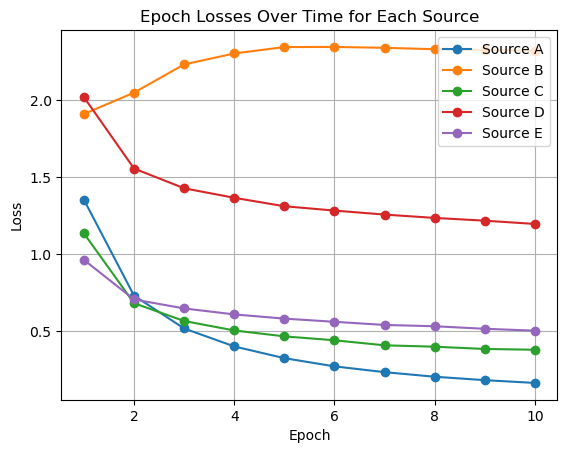

In [41]:
epoch_losses['E'] = [(e + f) / 2 for e, f in zip(epoch_losses['E'], epoch_losses['F'])]
del epoch_losses['F']  # Remove the old 'F' data

# Plotting the results
for source in epoch_losses:
    plt.plot(range(1, len(epoch_losses[source]) + 1), epoch_losses[source], marker='o', label=f'Source {source}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Losses Over Time for Each Source')
plt.legend()
plt.grid(True)
plt.show()

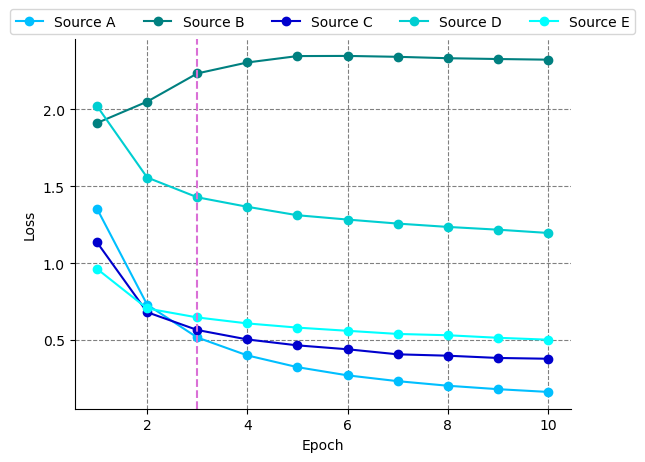

In [74]:
# Colors to use for the plots
colors = ['deepskyblue', 'teal', 'mediumblue', 'darkturquoise', 'aqua']

# Plotting the results
for idx, (source, color) in enumerate(zip(epoch_losses, colors)):
    plt.plot(range(1, len(epoch_losses[source]) + 1), epoch_losses[source], marker='o', color=color, label=f'Source {source}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# Title removed as per your request

# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add grey dashed grid lines
plt.grid(True, linestyle='--', color='grey')

# Add a vertical line at epoch 3
plt.axvline(x=3, color='orchid', linestyle='--', linewidth=1.5)

# Add a horizontal legend at the top, moved up a bit
plt.legend(loc='upper center', ncol=len(epoch_losses), bbox_to_anchor=(0.5, 1.10))

plt.show()

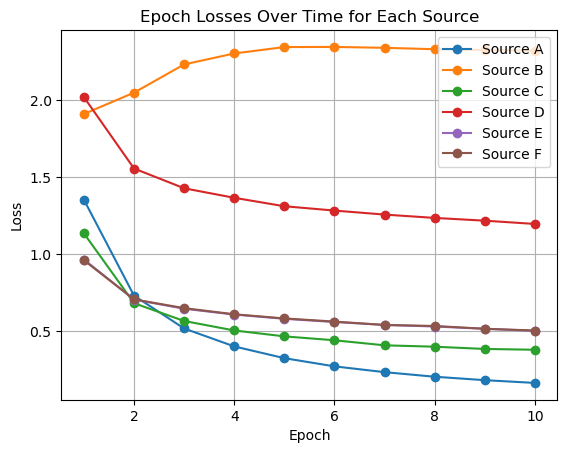

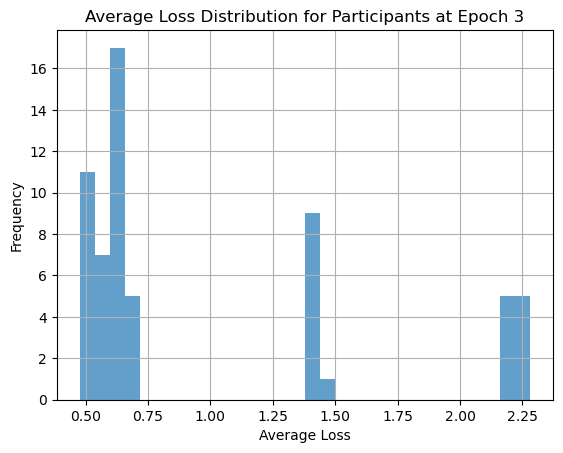

In [19]:

plt.figure()
plt.hist(target_epoch_participant_losses, bins=30, alpha=0.7)
plt.xlabel('Average Loss')
plt.ylabel('Frequency')
plt.title(f'Average Loss Distribution for Participants at Epoch 3')
plt.grid(True)
plt.show()

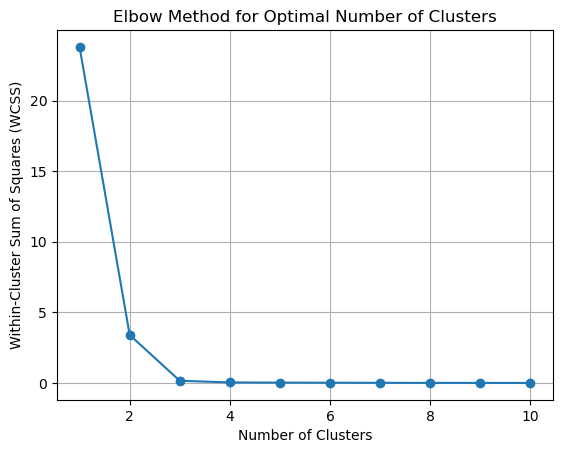

In [20]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Assuming target_epoch_losses is your list of individual losses at the second epoch
losses = np.array(target_epoch_participant_losses).reshape(-1, 1)

# Use the Elbow Method to find the optimal number of clusters
wcss = []
for i in range(1, 11):  # Test for 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(losses)
    wcss.append(kmeans.inertia_)


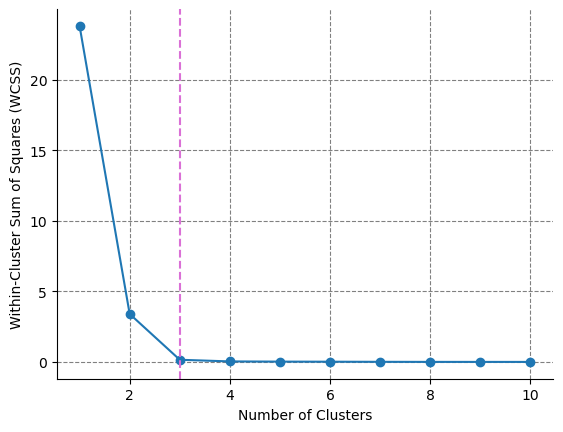

In [75]:
# Plot the Elbow graph
plt.figure()
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')

# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add dashed grid lines
plt.grid(True, linestyle='--', color='grey')

# Add a vertical line at epoch 3
plt.axvline(x=3, color='orchid', linestyle='--', linewidth=1.5)

plt.show()

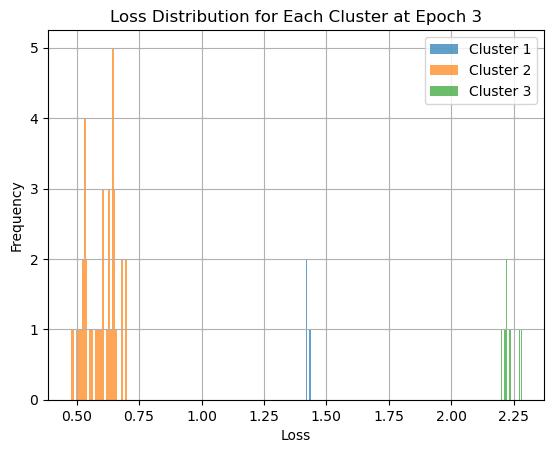

In [21]:
train_losses = np.array(target_epoch_participant_losses).reshape(-1, 1)

# Choose the number of clusters (e.g., 3)
num_clusters = 3

# Fit K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
train_clusters = kmeans.fit_predict(train_losses)

# Predict clusters for the test losses
test_losses = np.array(target_epoch_test_participant_losses).reshape(-1, 1)
test_clusters = kmeans.predict(test_losses)

# Plot the histogram with cluster information
for cluster in range(num_clusters):
    cluster_losses = train_losses[train_clusters == cluster]
    plt.hist(cluster_losses, bins=30, alpha=0.7, label=f'Cluster {cluster + 1}')

plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Loss Distribution for Each Cluster at Epoch 3')
plt.legend()
plt.grid(True)
plt.show()

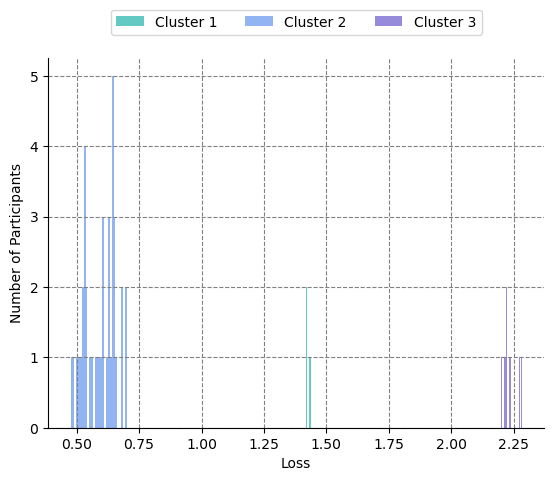

In [56]:
# Colors to use for the histograms
colors = ['lightseagreen', 'cornflowerblue', 'slateblue']

# Plot the histogram with cluster information
for cluster, color in zip(range(num_clusters), colors):
    cluster_losses = train_losses[train_clusters == cluster]
    plt.hist(cluster_losses, bins=30, alpha=0.7, color=color, label=f'Cluster {cluster + 1}')

plt.xlabel('Loss')
plt.ylabel('Number of Participants')
# Title removed as per your request

# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add grey dashed grid lines
plt.grid(True, linestyle='--', color='grey')

# Add a horizontal legend at the top, moved up a bit
plt.legend(loc='upper center', ncol=num_clusters, bbox_to_anchor=(0.5, 1.15))

plt.show()

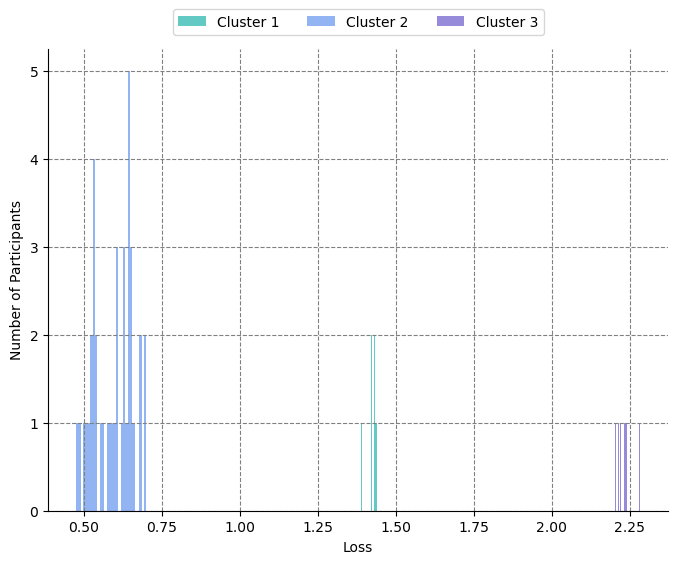

Number of participants in Cluster 1: 10
Number of participants in Cluster 2: 40
Number of participants in Cluster 3: 10


In [69]:
num_clusters = 3  # Number of clusters

# Colors to use for the histograms
colors = ['lightseagreen', 'cornflowerblue', 'slateblue']

# Plot the histogram with cluster information
plt.figure(figsize=(8, 6))
for cluster, color in zip(range(num_clusters), colors):
    cluster_losses = train_losses[train_clusters == cluster]
    plt.hist(cluster_losses, bins=30, alpha=0.7, color=color, label=f'Cluster {cluster + 1}')

plt.xlabel('Loss')
plt.ylabel('Number of Participants')
# Title removed as per your request

# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add grey dashed grid lines
plt.grid(True, linestyle='--', color='grey')

# Add a horizontal legend at the top, moved up a bit
plt.legend(loc='upper center', ncol=num_clusters, bbox_to_anchor=(0.5, 1.10))

plt.show()

# Display the number of participants in each cluster
for cluster in range(num_clusters):
    num_in_cluster = sum(train_clusters == cluster)
    print(f'Number of participants in Cluster {cluster + 1}: {num_in_cluster}')

In [63]:
# Display the number of participants in Cluster 1
num_in_cluster_1 = sum(train_clusters == 0)  # Assuming clusters are zero-indexed
print(f'Number of participants in Cluster 1: {num_in_cluster_1}')


Number of participants in Cluster 1: 10


In [22]:
# Create the mapping for train participants
train_participant_cluster_mapping = {participant_id: cluster for participant_id, cluster in enumerate(train_clusters)}

# Create the mapping for test participants
start_test_participant_id = len(train_clusters)  # Continue the participant IDs from where train ends
test_participant_cluster_mapping = {start_test_participant_id + participant_id: cluster for participant_id, cluster in enumerate(test_clusters)}

# Combine both mappings
participant_cluster_mapping = {**train_participant_cluster_mapping, **test_participant_cluster_mapping}

# Print the combined mapping
print("\nParticipant ID to Cluster mapping:")
for participant_id, cluster in participant_cluster_mapping.items():
    print(f"Participant {participant_id}: Cluster {cluster}")


Participant ID to Cluster mapping:
Participant 0: Cluster 2
Participant 1: Cluster 2
Participant 2: Cluster 2
Participant 3: Cluster 2
Participant 4: Cluster 2
Participant 5: Cluster 2
Participant 6: Cluster 2
Participant 7: Cluster 2
Participant 8: Cluster 2
Participant 9: Cluster 2
Participant 10: Cluster 1
Participant 11: Cluster 1
Participant 12: Cluster 1
Participant 13: Cluster 1
Participant 14: Cluster 1
Participant 15: Cluster 1
Participant 16: Cluster 1
Participant 17: Cluster 1
Participant 18: Cluster 1
Participant 19: Cluster 1
Participant 20: Cluster 0
Participant 21: Cluster 0
Participant 22: Cluster 0
Participant 23: Cluster 0
Participant 24: Cluster 0
Participant 25: Cluster 0
Participant 26: Cluster 0
Participant 27: Cluster 0
Participant 28: Cluster 0
Participant 29: Cluster 0
Participant 30: Cluster 1
Participant 31: Cluster 1
Participant 32: Cluster 1
Participant 33: Cluster 1
Participant 34: Cluster 1
Participant 35: Cluster 1
Participant 36: Cluster 1
Participant 

In [23]:
# Extract source labels and participant IDs from the train_dataset
source_labels_dict = {}
for i in range(len(train_dataset)):
    _, _, source_label, participant_id = train_dataset[i]
    if participant_id not in source_labels_dict:
        source_labels_dict[participant_id] = source_label

# Extract source labels and participant IDs from the test_dataset
for i in range(len(test_dataset)):
    _, _, source_label, participant_id = test_dataset[i]
    if participant_id not in source_labels_dict:
        source_labels_dict[participant_id] = source_label

# Verify mapping
print("Participant ID to Source Label mapping:")
for participant_id, source_label in source_labels_dict.items():
    print(f"Participant {participant_id}: Source {source_label}")

# Create source_labels list from the dictionary
source_labels = [source_labels_dict[participant_id] for participant_id in sorted(source_labels_dict.keys())]

# Print the source_labels list
print("\nSource Labels list:")
print(source_labels)

Participant ID to Source Label mapping:
Participant 0: Source B
Participant 1: Source B
Participant 2: Source B
Participant 3: Source B
Participant 4: Source B
Participant 5: Source B
Participant 6: Source B
Participant 7: Source B
Participant 8: Source B
Participant 9: Source B
Participant 10: Source C
Participant 11: Source C
Participant 12: Source C
Participant 13: Source C
Participant 14: Source C
Participant 15: Source C
Participant 16: Source C
Participant 17: Source C
Participant 18: Source C
Participant 19: Source C
Participant 20: Source D
Participant 21: Source D
Participant 22: Source D
Participant 23: Source D
Participant 24: Source D
Participant 25: Source D
Participant 26: Source D
Participant 27: Source D
Participant 28: Source D
Participant 29: Source D
Participant 30: Source E
Participant 31: Source E
Participant 32: Source E
Participant 33: Source E
Participant 34: Source E
Participant 35: Source E
Participant 36: Source E
Participant 37: Source E
Participant 38: Sour

In [24]:
# Check for missing participant IDs
missing_keys = [pid for pid in participant_cluster_mapping.keys() if pid not in source_labels_dict]
print(f"Missing participant IDs in source_labels_dict: {missing_keys}")

Missing participant IDs in source_labels_dict: []


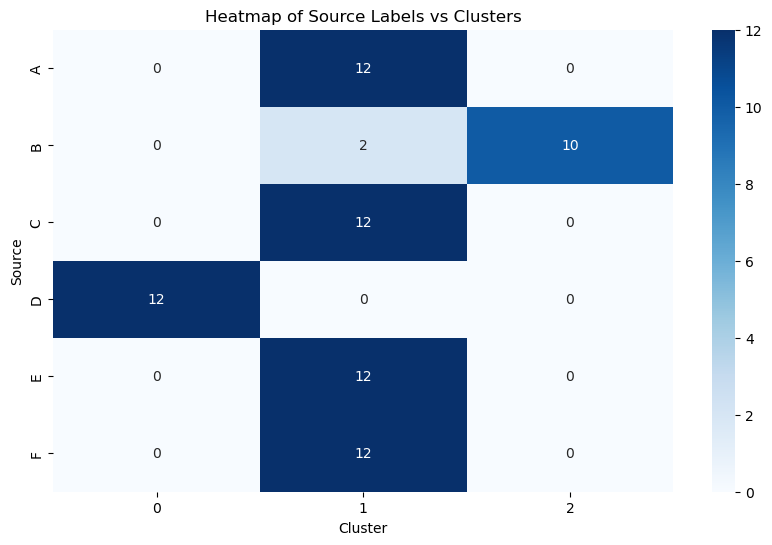

In [25]:
# Create a DataFrame for visualization
data = {
    'Participant ID': list(participant_cluster_mapping.keys()),
    'Cluster': list(participant_cluster_mapping.values()),
    'Source': [source_labels_dict[pid] for pid in participant_cluster_mapping.keys()]
}

df = pd.DataFrame(data)

# Create a contingency table
contingency_table = pd.crosstab(df['Source'], df['Cluster'])

# Visualize using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title('Heatmap of Source Labels vs Clusters')
plt.ylabel('Source')
plt.xlabel('Cluster')
plt.show()

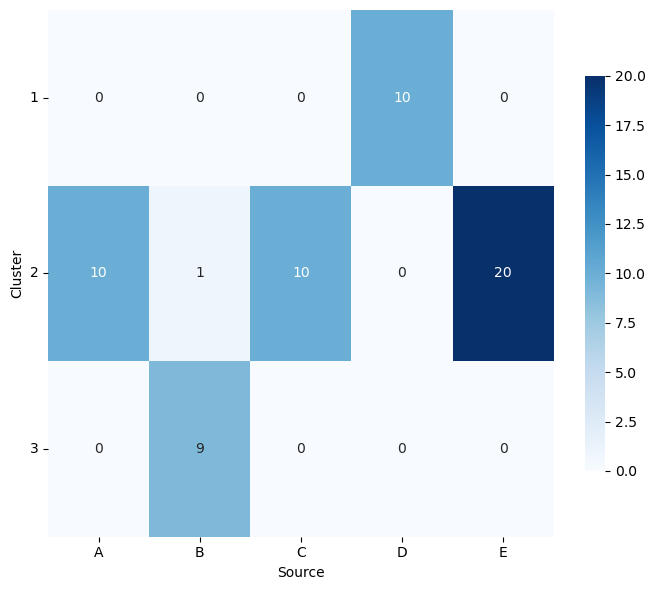

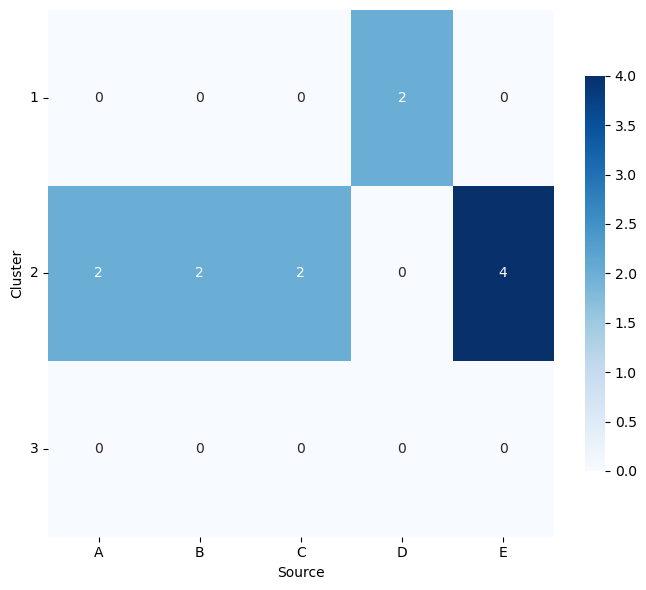

In [62]:
# Sample data and participant_cluster_mapping and source_labels_dict are assumed to be defined
data = {
    'Participant ID': list(participant_cluster_mapping.keys()),
    'Cluster': list(participant_cluster_mapping.values()),
    'Source': [source_labels_dict[pid] for pid in participant_cluster_mapping.keys()]
}

df = pd.DataFrame(data)

# Combine 'E' and 'F' sources into 'E'
df['Source'] = df['Source'].replace('F', 'E')

# Split the DataFrame into two based on Participant ID ranges
df1 = df[df['Participant ID'].isin(range(1, 61))]
df2 = df[df['Participant ID'].isin(range(60, 73))]

# Create contingency tables for both DataFrames
contingency_table1 = pd.crosstab(df1['Cluster'], df1['Source'])
contingency_table2 = pd.crosstab(df2['Cluster'], df2['Source'])

# Ensure all clusters are displayed, even if they have zero data points
for cluster in range(1, 3):
    if cluster not in contingency_table2.index:
        contingency_table2.loc[cluster] = 0
contingency_table2 = contingency_table2.sort_index()

# Visualize using heatmaps

# First heatmap
plt.figure(figsize=(7, 6))
ax1 = sns.heatmap(contingency_table1, annot=True, fmt='d', cmap='Blues', cbar=True, cbar_kws={'shrink': 0.75})
ax1.set_ylabel('Cluster')
ax1.set_xlabel('Source')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)  # Ensure labels are horizontal

# Manually set y-tick labels to start from 1
ax1.set_yticks(ax1.get_yticks())
ax1.set_yticklabels(range(1, len(ax1.get_yticks()) + 1))

plt.tight_layout()
plt.show()

# Second heatmap
plt.figure(figsize=(7, 6))
ax2 = sns.heatmap(contingency_table2, annot=True, fmt='d', cmap='Blues', cbar=True, cbar_kws={'shrink': 0.75})
ax2.set_ylabel('Cluster')
ax2.set_xlabel('Source')
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)  # Ensure labels are horizontal

# Manually set y-tick labels to start from 1
ax2.set_yticks(ax2.get_yticks())
ax2.set_yticklabels(range(1, len(ax2.get_yticks()) + 1))

plt.tight_layout()
plt.show()

Accuracy on the entire test set: 64.66%
Accuracy for Source A: 93.76%
Accuracy for Source B: 20.88%
Accuracy for Source C: 88.96%
Accuracy for Source D: 7.50%
Accuracy for Source E: 88.00%
Accuracy for Source F: 88.90%


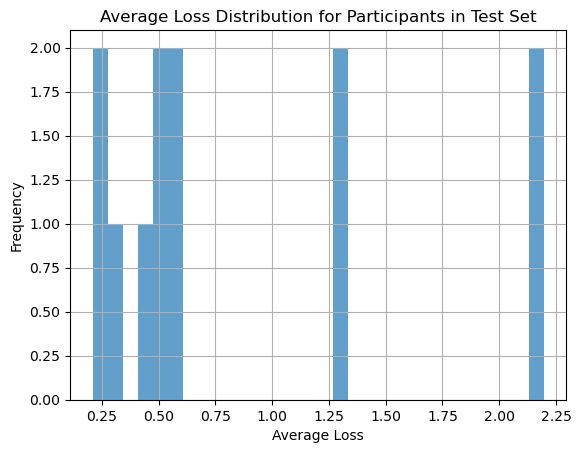

In [26]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # Initialize source-specific counters
    source_correct = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0}
    source_total = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0}
    source_running_loss = {'A': 0.0, 'B': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0, 'F': 0.0}

    # Initialize participant losses
    participant_losses = {}

    with torch.no_grad():
        for batch_idx, (images, labels, source_labels, participant_ids) in enumerate(test_loader):
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update source-specific counters and participant losses
            for i, (source, pred, label, participant_id) in enumerate(zip(source_labels, predicted, labels, participant_ids)):
                individual_loss = criterion(outputs[i].unsqueeze(0), label.unsqueeze(0)).item()
                if participant_id.item() not in participant_losses:
                    participant_losses[participant_id.item()] = []
                participant_losses[participant_id.item()].append(individual_loss)
                source_running_loss[source] += individual_loss

                if pred == label:
                    source_correct[source] += 1
                source_total[source] += 1

    accuracy = 100 * correct / total
    print(f'Accuracy on the entire test set: {accuracy:.2f}%')

    # Display source-specific accuracies
    for source in source_correct:
        if source_total[source] > 0:
            source_accuracy = (source_correct[source] / source_total[source]) * 100
            print(f'Accuracy for Source {source}: {source_accuracy:.2f}%')

    # Calculate average loss per participant
    participant_avg_losses = []
    for participant_id in participant_losses:
        if participant_losses[participant_id]:  # Avoid division by zero
            avg_loss = sum(participant_losses[participant_id]) / len(participant_losses[participant_id])
            participant_avg_losses.append(avg_loss)

    return participant_avg_losses

# Evaluate the model with source-specific accuracies and participant-specific losses
participant_avg_losses = evaluate_model(model, test_loader, criterion)

# Plot the histogram of participant losses
import matplotlib.pyplot as plt

plt.figure()
plt.hist(participant_avg_losses, bins=30, alpha=0.7)
plt.xlabel('Average Loss')
plt.ylabel('Frequency')
plt.title('Average Loss Distribution for Participants in Test Set')
plt.grid(True)
plt.show()

In [28]:
class CustomMNISTWithCluster(ParticipantCustomMNIST):
    def __init__(self, mnist_dataset, source_labels, participant_ids, participant_cluster_mapping, transform=None):
        super().__init__(mnist_dataset, source_labels, participant_ids, transform)
        self.participant_cluster_mapping = participant_cluster_mapping

    def __getitem__(self, idx):
        image, label, source_label, participant_id = super().__getitem__(idx)
        loss_cluster = self.participant_cluster_mapping[participant_id]
        return image, label, source_label, participant_id, loss_cluster

# Example instantiation
custom_train_dataset_with_cluster = CustomMNISTWithCluster(training_data, training_sources, train_participants, participant_cluster_mapping, transform=None)
custom_test_dataset_with_cluster = CustomMNISTWithCluster(test_data, test_sources, test_participants, participant_cluster_mapping, transform=None)


In [29]:
train_loader_loss = DataLoader(custom_train_dataset_with_cluster, batch_size=128, shuffle=True)
test_loader_loss = DataLoader(custom_test_dataset_with_cluster, batch_size=128, shuffle=False)

# loss mlp final layer

In [30]:
class LossMLP(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate):
        super(LossMLP, self).__init__()
        # Common layers for all clusters
        self.linear1 = nn.Linear(input_size, 100)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.linear2 = nn.Linear(100, 100)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Special final layer for each cluster
        self.linear3_cluster1 = nn.Linear(100, output_size)
        self.linear3_cluster2 = nn.Linear(100, output_size)
        self.linear3_cluster3 = nn.Linear(100, output_size)

    def forward(self, data, clusters):
        outputs = []
        for i, cluster in enumerate(clusters):
            x = F.relu(self.linear1(data[i]))
            x = self.dropout1(x)
            x = F.relu(self.linear2(x))
            x = self.dropout2(x)

            # Choose the final layer based on the loss cluster
            if cluster == 0:
                y_pred = self.linear3_cluster1(x)
            elif cluster == 1:
                y_pred = self.linear3_cluster2(x)
            elif cluster == 2:
                y_pred = self.linear3_cluster3(x)
            else:
                print(f"Unexpected cluster: {cluster}")
                raise ValueError("Unknown cluster provided: must be 0, 1, or 2")
            outputs.append(y_pred)
        return torch.stack(outputs)



In [31]:
def train_model(lossmodel, train_loader, criterion, optimizerloss, num_epochs):
    lossmodel.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        source_correct = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0}
        source_total = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0}

        for batch_idx, (images, labels, source_labels, participant_ids, loss_clusters) in enumerate(train_loader):
            optimizerloss.zero_grad()
            outputs = lossmodel(images, loss_clusters)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizerloss.step()

            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            for source, pred, label in zip(source_labels, predicted, labels):
                if pred == label:
                    source_correct[source] += 1
                source_total[source] += 1

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = (correct_predictions / total_predictions) * 100

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
        for source in source_correct:
            if source_total[source] > 0:
                source_accuracy = (source_correct[source] / source_total[source]) * 100
                print(f'Accuracy for Source {source}: {source_accuracy:.2f}%')

def validate_model(lossmodel, val_loader, criterion):
    lossmodel.eval()
    val_running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    source_correct = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0}
    source_total = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0}

    with torch.no_grad():
        for batch_idx, (images, labels, source_labels, participant_ids, loss_clusters) in enumerate(val_loader):
            outputs = lossmodel(images, loss_clusters)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            for source, pred, label in zip(source_labels, predicted, labels):
                if pred == label:
                    source_correct[source] += 1
                source_total[source] += 1

    val_loss = val_running_loss / len(val_loader.dataset)
    val_accuracy = correct_predictions / total_predictions * 100.0

    source_accuracies = {}
    for source in source_correct:
        if source_total[source] > 0:
            source_accuracy = (source_correct[source] / source_total[source]) * 100
            source_accuracies[source] = source_accuracy

    return val_loss, val_accuracy, source_accuracies

In [32]:
# Hyperparameter grid
hyperparameter_grid = {
    'lr': [0.001, 0.005, 0.01],
    'dropout_rate': [0, 0.2, 0.5]
}

best_accuracy = 0
best_model_state = None
best_hyperparams = None

# Create all possible combinations of hyperparameters
all_combinations = list(itertools.product(*hyperparameter_grid.values()))

# Cross-validation and hyperparameter tuning
kf = KFold(n_splits=5, shuffle=True, random_state=42)
criterion = nn.CrossEntropyLoss()

for lr, dropout_rate in all_combinations:
    fold_accuracies = []
    fold_source_accuracies = {'A': [], 'B': [], 'C': [], 'D': [], 'E': [], 'F': []}
    print(f'Testing parameters: lr={lr}, dropout_rate={dropout_rate}')
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(custom_train_dataset_with_cluster)))):
        print(f'Starting Fold {fold+1}')
        train_subset = Subset(custom_train_dataset_with_cluster, train_idx)
        val_subset = Subset(custom_train_dataset_with_cluster, val_idx)
        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

        lossmodel = LossMLP(input_size=784, output_size=10, dropout_rate=dropout_rate)
        optimizerloss = torch.optim.Adam(lossmodel.parameters(), lr=lr)

        train_model(lossmodel, train_loader, criterion, optimizerloss, num_epochs=10)
        val_loss, val_acc, source_accuracies = validate_model(lossmodel, val_loader, criterion)
        fold_accuracies.append(val_acc)
        for source in source_accuracies:
            fold_source_accuracies[source].append(source_accuracies[source])

    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_hyperparams = {'lr': lr, 'dropout_rate': dropout_rate}
        best_model = lossmodel

    print(f'Parameters: lr={lr}, dropout_rate={dropout_rate}, Mean Accuracy: {mean_accuracy:.2f}%, Std Dev: {std_accuracy:.2f}%')
    for source in fold_source_accuracies:
        mean_source = np.mean(fold_source_accuracies[source])
        std_source = np.std(fold_source_accuracies[source])
        print(f'Source {source} - Mean: {mean_source:.2f}%, Std Dev: {std_source:.2f}%')

print(f'Best Hyperparameters: {best_hyperparams}, with mean accuracy: {best_accuracy:.2f}%')

Testing parameters: lr=0.001, dropout_rate=0
Starting Fold 1
Epoch 1/10, Loss: 0.9603, Accuracy: 69.51%
Accuracy for Source A: 53.15%
Accuracy for Source B: 52.20%
Accuracy for Source C: 72.58%
Accuracy for Source D: 79.00%
Accuracy for Source E: 80.06%
Accuracy for Source F: 80.00%
Epoch 2/10, Loss: 0.6084, Accuracy: 80.67%
Accuracy for Source A: 80.60%
Accuracy for Source B: 48.12%
Accuracy for Source C: 83.58%
Accuracy for Source D: 90.90%
Accuracy for Source E: 90.33%
Accuracy for Source F: 90.48%
Epoch 3/10, Loss: 0.5846, Accuracy: 80.77%
Accuracy for Source A: 87.34%
Accuracy for Source B: 33.49%
Accuracy for Source C: 86.12%
Accuracy for Source D: 93.12%
Accuracy for Source E: 92.35%
Accuracy for Source F: 92.19%
Epoch 4/10, Loss: 0.5818, Accuracy: 80.53%
Accuracy for Source A: 89.73%
Accuracy for Source B: 23.56%
Accuracy for Source C: 87.81%
Accuracy for Source D: 94.52%
Accuracy for Source E: 93.61%
Accuracy for Source F: 93.90%
Epoch 5/10, Loss: 0.5769, Accuracy: 80.04%
Accu

In [34]:
# Bootstrap sampling and testing
def bootstrap_train_and_test(lossmodel, train_data, test_loader, criterion, optimizer_params, num_epochs=10, num_bootstrap=5, sample_percentage=0.8):
    bootstrap_accuracies = []
    source_bootstrap_accuracies = {source: [] for source in 'ABCDEF'}
    for i in range(num_bootstrap):
        # Create a bootstrap sample from the training data
        indices = np.random.choice(len(train_data), size=int(sample_percentage * len(train_data)), replace=True)
        bootstrap_subset = Subset(train_data, indices)
        bootstrap_loader = DataLoader(bootstrap_subset, batch_size=128, shuffle=True)

        # Initialize and train the model
        optimizerloss = torch.optim.Adam(lossmodel.parameters(), **optimizer_params)

        for epoch in range(num_epochs):
            lossmodel.train()
            for images, labels, source_labels, participant_ids, loss_clusters in bootstrap_loader:
                optimizerloss.zero_grad()
                outputs = lossmodel(images, loss_clusters)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizerloss.step()

        # Evaluate on the test set
        lossmodel.eval()
        test_loss, correct, total = 0, 0, 0
        source_counts = {s: 0 for s in 'ABCDEF'}
        source_correct = {s: 0 for s in 'ABCDEF'}
        with torch.no_grad():
            for images, labels, source_labels, participant_ids, loss_clusters in test_loader:
                outputs = lossmodel(images, loss_clusters)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                for i, source in enumerate(source_labels):
                    source_counts[source] += 1
                    if predicted[i] == labels[i]:
                        source_correct[source] += 1

        accuracy = correct / total * 100.0
        bootstrap_accuracies.append(accuracy)
        source_accuracies = {s: (source_correct[s] / source_counts[s] * 100) if source_counts[s] > 0 else 0 for s in 'ABCDEF'}
        for source in source_accuracies:
            source_bootstrap_accuracies[source].append(source_accuracies[source])

    mean_accuracy = np.mean(bootstrap_accuracies)
    std_accuracy = np.std(bootstrap_accuracies)
    mean_source_accuracies = {s: np.mean(source_bootstrap_accuracies[s]) for s in 'ABCDEF'}
    std_source_accuracies = {s: np.std(source_bootstrap_accuracies[s]) for s in 'ABCDEF'}

    return mean_accuracy, std_accuracy, mean_source_accuracies, std_source_accuracies

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Perform bootstrap training and testing
mean_bootstrap, std_bootstrap, mean_source_accuracies, std_source_accuracies = bootstrap_train_and_test(
    best_model, custom_train_dataset_with_cluster, test_loader_loss, criterion, {'lr': best_hyperparams['lr']}, num_epochs=10, num_bootstrap=5, sample_percentage=0.8
)

print(f'Bootstrap results: Mean accuracy: {mean_bootstrap:.2f}%, Std Dev: {std_bootstrap:.2f}%')
for source in mean_source_accuracies:
    print(f'Source {source} - Bootstrap Mean: {mean_source_accuracies[source]:.2f}%, Std Dev: {std_source_accuracies[source]:.2f}%')

Bootstrap results: Mean accuracy: 83.83%, Std Dev: 3.65%
Source A - Bootstrap Mean: 94.41%, Std Dev: 0.28%
Source B - Bootstrap Mean: 27.21%, Std Dev: 22.65%
Source C - Bootstrap Mean: 90.88%, Std Dev: 0.76%
Source D - Bootstrap Mean: 97.11%, Std Dev: 0.11%
Source E - Bootstrap Mean: 96.71%, Std Dev: 0.23%
Source F - Bootstrap Mean: 96.67%, Std Dev: 0.28%


# loss mlp separate

In [35]:
class LossSeparateMLP(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate):
        super(LossSeparateMLP, self).__init__()
        # Separate layers for source A
        self.linear1_1 = nn.Linear(input_size, 100)
        self.dropout1_1 = nn.Dropout(dropout_rate)
        self.linear2_1 = nn.Linear(100, 100)
        self.dropout2_1 = nn.Dropout(dropout_rate)
        self.linear3_1 = nn.Linear(100, output_size)
        
        # Separate layers for source B
        self.linear1_2 = nn.Linear(input_size, 100)
        self.dropout1_2 = nn.Dropout(dropout_rate)
        self.linear2_2 = nn.Linear(100, 100)
        self.dropout2_2 = nn.Dropout(dropout_rate)
        self.linear3_2 = nn.Linear(100, output_size)
        
        # Separate layers for source C
        self.linear1_3 = nn.Linear(input_size, 100)
        self.dropout1_3 = nn.Dropout(dropout_rate)
        self.linear2_3 = nn.Linear(100, 100)
        self.dropout2_3 = nn.Dropout(dropout_rate)
        self.linear3_3 = nn.Linear(100, output_size)

    def forward(self, data, clusters):
        outputs = []
        for i, cluster in enumerate(clusters):
            if cluster == 0:
                x = F.relu(self.linear1_1(data[i]))
                x = self.dropout1_1(x)
                x = F.relu(self.linear2_1(x))
                x = self.dropout2_1(x)
                y_pred = self.linear3_1(x)
            elif cluster == 1:
                x = F.relu(self.linear1_2(data[i]))
                x = self.dropout1_2(x)
                x = F.relu(self.linear2_2(x))
                x = self.dropout2_2(x)
                y_pred = self.linear3_2(x)
            elif cluster == 2:
                x = F.relu(self.linear1_3(data[i]))
                x = self.dropout1_3(x)
                x = F.relu(self.linear2_3(x))
                x = self.dropout2_3(x)
                y_pred = self.linear3_3(x)
            else:
                print(f"Unexpected cluster: {cluster}")
                raise ValueError("Unknown cluster provided: must be 0, 1, or 2")
            outputs.append(y_pred)
        return torch.stack(outputs)

In [36]:
def train_model(lossmodel, train_loader, criterion, optimizerloss, num_epochs):
    lossmodel.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        source_correct = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0}
        source_total = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0}

        for batch_idx, (images, labels, source_labels, participant_ids, loss_clusters) in enumerate(train_loader):
            optimizerloss.zero_grad()
            outputs = lossmodel(images, loss_clusters)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizerloss.step()

            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            for source, pred, label in zip(source_labels, predicted, labels):
                if pred == label:
                    source_correct[source] += 1
                source_total[source] += 1

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = (correct_predictions / total_predictions) * 100

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
        for source in source_correct:
            if source_total[source] > 0:
                source_accuracy = (source_correct[source] / source_total[source]) * 100
                print(f'Accuracy for Source {source}: {source_accuracy:.2f}%')

def validate_model(lossmodel, val_loader, criterion):
    lossmodel.eval()
    val_running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    source_correct = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0}
    source_total = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0}

    with torch.no_grad():
        for batch_idx, (images, labels, source_labels, participant_ids, loss_clusters) in enumerate(val_loader):
            outputs = lossmodel(images, loss_clusters)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            for source, pred, label in zip(source_labels, predicted, labels):
                if pred == label:
                    source_correct[source] += 1
                source_total[source] += 1

    val_loss = val_running_loss / len(val_loader.dataset)
    val_accuracy = correct_predictions / total_predictions * 100.0

    source_accuracies = {}
    for source in source_correct:
        if source_total[source] > 0:
            source_accuracy = (source_correct[source] / source_total[source]) * 100
            source_accuracies[source] = source_accuracy

    return val_loss, val_accuracy, source_accuracies

In [37]:
# Hyperparameter grid
hyperparameter_grid = {
    'lr': [0.001, 0.005, 0.01],
    'dropout_rate': [0, 0.2, 0.5]
}

best_accuracy = 0
best_model_state = None
best_hyperparams = None

# Create all possible combinations of hyperparameters
all_combinations = list(itertools.product(*hyperparameter_grid.values()))

# Cross-validation and hyperparameter tuning
kf = KFold(n_splits=5, shuffle=True, random_state=42)
criterion = nn.CrossEntropyLoss()

for lr, dropout_rate in all_combinations:
    fold_accuracies = []
    fold_source_accuracies = {'A': [], 'B': [], 'C': [], 'D': [], 'E': [], 'F': []}
    print(f'Testing parameters: lr={lr}, dropout_rate={dropout_rate}')
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(custom_train_dataset_with_cluster)))):
        print(f'Starting Fold {fold+1}')
        train_subset = Subset(custom_train_dataset_with_cluster, train_idx)
        val_subset = Subset(custom_train_dataset_with_cluster, val_idx)
        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

        lossmodel = LossSeparateMLP(input_size=784, output_size=10, dropout_rate=dropout_rate)
        optimizerloss = torch.optim.Adam(lossmodel.parameters(), lr=lr)

        train_model(lossmodel, train_loader, criterion, optimizerloss, num_epochs=10)
        val_loss, val_acc, source_accuracies = validate_model(lossmodel, val_loader, criterion)
        fold_accuracies.append(val_acc)
        for source in source_accuracies:
            fold_source_accuracies[source].append(source_accuracies[source])

    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_hyperparams = {'lr': lr, 'dropout_rate': dropout_rate}
        best_model = lossmodel

    print(f'Parameters: lr={lr}, dropout_rate={dropout_rate}, Mean Accuracy: {mean_accuracy:.2f}%, Std Dev: {std_accuracy:.2f}%')
    for source in fold_source_accuracies:
        mean_source = np.mean(fold_source_accuracies[source])
        std_source = np.std(fold_source_accuracies[source])
        print(f'Source {source} - Mean: {mean_source:.2f}%, Std Dev: {std_source:.2f}%')

print(f'Best Hyperparameters: {best_hyperparams}, with mean accuracy: {best_accuracy:.2f}%')

Testing parameters: lr=0.001, dropout_rate=0
Starting Fold 1
Epoch 1/10, Loss: 1.0932, Accuracy: 62.99%
Accuracy for Source A: 58.31%
Accuracy for Source B: 10.31%
Accuracy for Source C: 69.85%
Accuracy for Source D: 81.88%
Accuracy for Source E: 78.90%
Accuracy for Source F: 78.64%
Epoch 2/10, Loss: 0.7371, Accuracy: 74.49%
Accuracy for Source A: 80.64%
Accuracy for Source B: 11.36%
Accuracy for Source C: 81.86%
Accuracy for Source D: 92.38%
Accuracy for Source E: 90.52%
Accuracy for Source F: 90.18%
Epoch 3/10, Loss: 0.6482, Accuracy: 77.09%
Accuracy for Source A: 87.79%
Accuracy for Source B: 11.36%
Accuracy for Source C: 83.73%
Accuracy for Source D: 94.38%
Accuracy for Source E: 92.88%
Accuracy for Source F: 92.41%
Epoch 4/10, Loss: 0.6029, Accuracy: 78.42%
Accuracy for Source A: 90.56%
Accuracy for Source B: 11.36%
Accuracy for Source C: 84.90%
Accuracy for Source D: 95.78%
Accuracy for Source E: 94.24%
Accuracy for Source F: 93.70%
Epoch 5/10, Loss: 0.5682, Accuracy: 79.60%
Accu

In [38]:
# Bootstrap sampling and testing
def bootstrap_train_and_test(lossmodel, train_data, test_loader, criterion, optimizer_params, num_epochs=10, num_bootstrap=5, sample_percentage=0.8):
    bootstrap_accuracies = []
    source_bootstrap_accuracies = {source: [] for source in 'ABCDEF'}
    for i in range(num_bootstrap):
        # Create a bootstrap sample from the training data
        indices = np.random.choice(len(train_data), size=int(sample_percentage * len(train_data)), replace=False)
        bootstrap_subset = Subset(train_data, indices)
        bootstrap_loader = DataLoader(bootstrap_subset, batch_size=128, shuffle=True)

        # Initialize and train the model
        optimizerloss = torch.optim.Adam(lossmodel.parameters(), **optimizer_params)

        for epoch in range(num_epochs):
            lossmodel.train()
            for images, labels, source_labels, participant_ids, loss_clusters in bootstrap_loader:
                optimizerloss.zero_grad()
                outputs = lossmodel(images, loss_clusters)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizerloss.step()

        # Evaluate on the test set
        lossmodel.eval()
        test_loss, correct, total = 0, 0, 0
        source_counts = {s: 0 for s in 'ABCDEF'}
        source_correct = {s: 0 for s in 'ABCDEF'}
        with torch.no_grad():
            for images, labels, source_labels, participant_ids, loss_clusters in test_loader:
                outputs = lossmodel(images, loss_clusters)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                for i, source in enumerate(source_labels):
                    source_counts[source] += 1
                    if predicted[i] == labels[i]:
                        source_correct[source] += 1

        accuracy = correct / total * 100.0
        bootstrap_accuracies.append(accuracy)
        source_accuracies = {s: (source_correct[s] / source_counts[s] * 100) if source_counts[s] > 0 else 0 for s in 'ABCDEF'}
        for source in source_accuracies:
            source_bootstrap_accuracies[source].append(source_accuracies[source])

    mean_accuracy = np.mean(bootstrap_accuracies)
    std_accuracy = np.std(bootstrap_accuracies)
    mean_source_accuracies = {s: np.mean(source_bootstrap_accuracies[s]) for s in 'ABCDEF'}
    std_source_accuracies = {s: np.std(source_bootstrap_accuracies[s]) for s in 'ABCDEF'}

    return mean_accuracy, std_accuracy, mean_source_accuracies, std_source_accuracies

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Perform bootstrap training and testing
mean_bootstrap, std_bootstrap, mean_source_accuracies, std_source_accuracies = bootstrap_train_and_test(
    best_model, custom_train_dataset_with_cluster, test_loader_loss, criterion, {'lr': best_hyperparams['lr']}, num_epochs=10, num_bootstrap=5, sample_percentage=0.8
)

print(f'Bootstrap results: Mean accuracy: {mean_bootstrap:.2f}%, Std Dev: {std_bootstrap:.2f}%')
for source in mean_source_accuracies:
    print(f'Source {source} - Bootstrap Mean: {mean_source_accuracies[source]:.2f}%, Std Dev: {std_source_accuracies[source]:.2f}%')

Bootstrap results: Mean accuracy: 80.81%, Std Dev: 0.37%
Source A - Bootstrap Mean: 95.16%, Std Dev: 0.30%
Source B - Bootstrap Mean: 9.77%, Std Dev: 0.98%
Source C - Bootstrap Mean: 90.55%, Std Dev: 0.88%
Source D - Bootstrap Mean: 96.03%, Std Dev: 0.41%
Source E - Bootstrap Mean: 96.59%, Std Dev: 0.35%
Source F - Bootstrap Mean: 96.77%, Std Dev: 0.15%
